# Pipeline
## Outline
1. Setup:
    - Import utilities files
    - Make sure the ROOT_DIR is testing-framework and file paths make sense
    - Specify the dataset you are working with / the path to the data. This will automatically create a directory with CSVs, plots as subfolders
3. Run large gridsearch using combination of matlab r=0.2 to 0.6 (CDFs/mtlb10000) and large grid (CDFs/grid10000) to obtain precision 1 best params
4. Run optimize_params with starting points given by grid_params_df
5. Use kstest_custom to carry out hypothesis test with best parameters found and check the p-value
6. Create subsets of the data by randomly sampling without replacement from the sample to run the kstest on smaller samples 

## Setup

In [12]:
import pywt
import pywt.data
from PIL import Image

In [13]:
os.getcwd()
# Input as ROOT_DIR

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'

In [14]:
from utilities import *
from plot_utilities import *

# Depending on your OS, file paths below may look different. Check the relative paths of each file from your pane
ROOT_DIR = '\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'
RAW_DATA_DIR = '..\\data\\Panoptic Agriculture\\Cleaned Dataset'
TRANSFORMED_DATA_DIR = '..\\data\\Panoptic Agriculture\\Transformed Dataset\\'
DATA_NAME = "Panoptic_Data_Dict_Normalized"

# Load samples from images and store in a pickle (only need to do one time)
norm_converted = convert_to_wavelet_basis(RAW_DATA_DIR, normalized = True)
dict_to_pickle(TRANSFORMED_DATA_DIR, norm_converted, DATA_NAME)

# For loading in data in the future
data_dict = pd.read_pickle(os.path.join(TRANSFORMED_DATA_DIR, DATA_NAME + ".pickle"))



8 layers being used


In [15]:
DATASET = "test"
os.mkdir(DATASET)
os.mkdir(os.path.join(DATASET, "CSVs"))
os.mkdir(os.path.join(DATASET, "plots"))

## Run large grid search

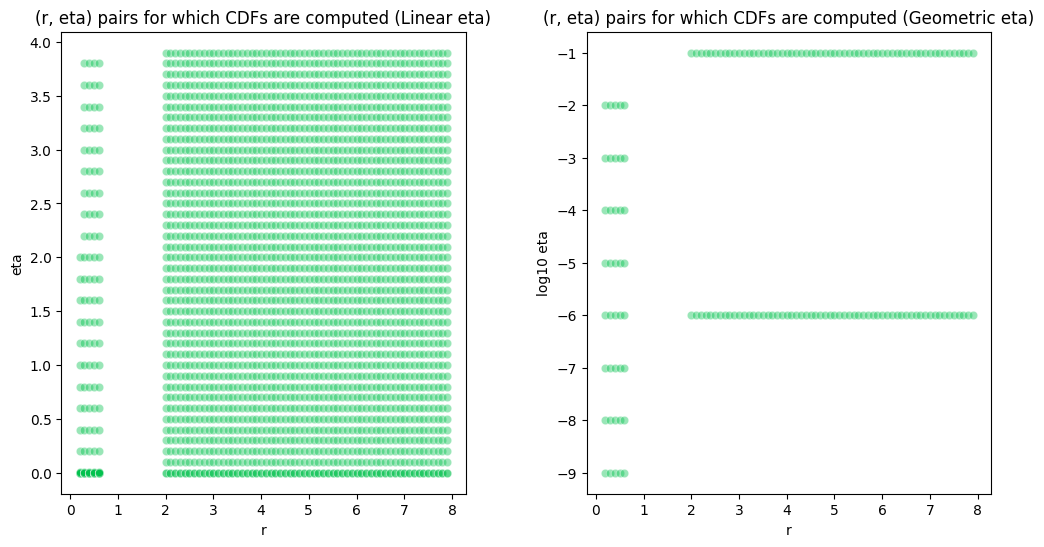

In [18]:
# Load CDFs
all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000')

all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : all_cdfs.items()})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)


In [ ]:
obs_x_dict = dict()
df_dict = dict()
best_params_df = pd.DataFrame(columns = ['layer', 'num_samples', 'r', 'eta', 'kstest_stat', 'kstest_pval'])
# Can take a very long time to run, better to run it in a .py
for i, layer in enumerate(np.arange(8, 9)): 
    obs_x = create_obs_x(data_dict, layer)
    obs_x_dict[layer] = obs_x
    df = make_layer_df(obs_x, all_cdfs_df)
    df_dict[layer] = df
    n = obs_x.size
    result = find_best_metric(obs_x, all_cdfs_df)
    best_params_df.loc[i, :] = np.append(np.array([layer, n]), result)

with (f'{DATASET}_obs_x_dict.pickle', 'wb') as handle:
    pickle.dump(obs_x_dict, handle)